# Recommender System - Baseline Model
This notebook implements a simple baseline which is collaborative filtering Matrix Factorization.

In [1]:
import os
import math
import random
import numpy as np
import pandas as pd
import time
import gc
import matplotlib.pyplot as plt
from collections import defaultdict

from numba.core.compiler_machinery import pass_info
from prompt_toolkit.contrib.telnet import TelnetServer

os.environ["HF_HOME"] = "D:/Python Projects/recommendation_system"
os.environ["HF_DATASETS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/data"
os.environ["TRANSFORMERS_CACHE"] = "D:/Python Projects/recommendation_system/recsys/models"

# os.environ["HF_HOME"] = "E:/Python Scripts/recsys"
# os.environ['HF_DATASETS_CACHE'] = "E:/Python Scripts/recsys/data"
# os.environ['TRANSFORMERS_CACHE'] = "E:/Python Scripts/recsys/models"

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from recommenders.datasets.python_splitters import (
    python_chrono_split, python_stratified_split, python_random_split
)

from datasets import load_dataset, Features, Value
from tqdm import tqdm
from tensorboardX import SummaryWriter

In [2]:
SEED = 42
def set_seed(seed=SEED):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

set_seed(SEED)
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("DEVICE:", DEVICE)

DEVICE: cuda


## Loading the dataset
The dataset is loaded from the Hugging Face datasets library, Amazon Reviews 2023.

In [3]:
USE_HF = True
HF_DATASET = "McAuley-Lab/Amazon-Reviews-2023"
HF_DOMAIN = "Movies_and_TV"   # choose your domain

def load_amazon_reviews_fast(domain: str, max_items: int | None = None, seed: int = SEED) -> pd.DataFrame:
    ds = load_dataset(
        "McAuley-Lab/Amazon-Reviews-2023",
        f"raw_review_{domain}",
        split="full",
        trust_remote_code=True,
    )

    # Keep only needed columns early
    ds = ds.select_columns(["user_id", "parent_asin", "rating", "verified_purchase", "timestamp"])

    # Rename + cast in Arrow (vectorized; no Python loop)
    ds = ds.rename_columns({"user_id": "user", "parent_asin": "item"})
    ds = ds.cast(Features({
        "user": Value("string"),
        "item": Value("string"),
        "rating": Value("float32"),
        "verified_purchase": Value("bool"),
        "timestamp": Value("int64"),   # seconds or ms as stored
    }))

    # Fast random subset without building a huge pandas frame first
    if max_items is not None:
        k = min(max_items, ds.num_rows)
        ds = ds.shuffle(seed=seed).select(range(k))

    # Convert to pandas (Arrow zero-copy where possible)
    df = ds.to_pandas()   # much faster than manual row loop
    df.insert(3, "domain", domain)  # add domain column to match your schema
    return df

# usage
df = load_amazon_reviews_fast(HF_DOMAIN, max_items=None, seed=SEED)
print(f"Loaded {len(df)} rows from {HF_DOMAIN} domain.")

Loaded 17328314 rows from Movies_and_TV domain.


In [4]:
df.head()

,user,item,rating,domain,verified_purchase,timestamp
0,AGGZ357AO26RQZVRLGU4D4N52DZQ,B013488XFS,5.0,Movies_and_TV,True,1440385637000
1,AGKASBHYZPGTEPO6LWZPVJWB2BVA,B00CB6VTDS,5.0,Movies_and_TV,True,1461100610000
2,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,B096Z8Z3R6,3.0,Movies_and_TV,True,1646271834582
3,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,B09M14D9FZ,4.0,Movies_and_TV,False,1645937761864
4,AG2L7H23R5LLKDKLBEF2Q3L2MVDA,B001H1SVZC,5.0,Movies_and_TV,True,1590639227074


## Preprocessing the dataset
- Make it implicit by considering all ratings as positive interactions.
- Filter out users and items with less than 5 interactions.
- Create a mapping of user and item IDs to indices.

In [102]:
# Make implicit dataset, filter users/items with less than 5 interactions, and encode user/item IDs
def preprocess_dataset(df, min_user_interactions=5, min_item_interactions=5):
    # Make it implicit
    df["label"] = 1.0
    # Filter users and items with less than 5 interactions
    user_counts = df["user"].value_counts()
    item_counts = df["item"].value_counts()
    valid_users = user_counts[user_counts >= min_user_interactions].index
    valid_items = item_counts[item_counts >= min_item_interactions].index
    df = df[df["user"].isin(valid_users) & df["item"].isin(valid_items)].copy()
    print("After interactions filtering:", len(df), "rows,", df["user"].nunique(), "users,", df["item"].nunique(), "items")
    return df

def label_encoder(df):
    user_enc = LabelEncoder()
    item_enc = LabelEncoder()
    df["user_id"] = user_enc.fit_transform(df["user"])
    df["item_id"] = item_enc.fit_transform(df["item"])
    return {"encoded_df": df,
            "user_encoder": user_enc,
            "item_encoder": item_enc}

filtered_df = preprocess_dataset(df, min_user_interactions=20, min_item_interactions=20)
le = label_encoder(filtered_df)
filtered_df = le["encoded_df"]
user_enc = le["user_encoder"]
item_enc = le["item_encoder"]

After interactions filtering: 2557292 rows, 75821 users, 114321 items


In [6]:
def calculate_data_sparsity(df):
    num_users = df["user"].nunique()
    num_items = df["item"].nunique()
    num_interactions = len(df)
    density = num_interactions / (num_users * num_items)
    sparsity = 1 - density

    print(f"Number of users: {num_users}")
    print(f"Number of items: {num_items}")
    print(f"Number of interactions: {num_interactions}")
    print(f"-" * 30)
    print(f"Interaction Matrix Density: {density:.4f}")
    print(f"Interaction Matrix Sparsity: {sparsity:.4f}")

calculate_data_sparsity(filtered_df)

Number of users: 75821
Number of items: 114321
Number of interactions: 2557292
------------------------------
Interaction Matrix Density: 0.0003
Interaction Matrix Sparsity: 0.9997


In [7]:
def loo_split(df, oversample_verified=False, oversample_factor=2):
    df = df.sort_values(["user_id", "timestamp"])
    train_rows, val_rows, test_rows = [], [], []
    for uid, group in df.groupby("user_id", sort=False):
        g = group.sort_values("timestamp")
        if len(g) < 5:
            train_rows.append(g)
            continue
        test_rows.append(g.iloc[[-1]])  # Last interaction as test
        val_rows.append(g.iloc[[-2]])    # Second last interaction as validation
        train_rows.append(g.iloc[:-2])    # All but last two as training

    train_df = pd.concat(train_rows, ignore_index=True)
    val_df = pd.concat(val_rows, ignore_index=True)
    test_df = pd.concat(test_rows, ignore_index=True)

    if oversample_verified and oversample_factor > 1:
        verified_rows = train_df.loc[train_df["verified_purchase"] == True]
        if not verified_rows.empty:
            train_df = pd.concat([train_df] + [verified_rows] * (oversample_factor - 1), ignore_index=True)

    return train_df, val_df, test_df

train_df, val_df, test_df = loo_split(filtered_df, oversample_verified=False, oversample_factor=1)
print(f"Train/Validation/Test split: {len(train_df)}, {len(val_df)}, {len(test_df)}")

Train/Validation/Test split: 2406272, 75510, 75510


## Building the dataset with negative sampling

In [8]:
NUM_USERS = filtered_df["user_id"].max() + 1
NUM_ITEMS = filtered_df["item_id"].max() + 1

In [9]:
# Rank the single positive against k negative samples for train and evaluation
def build_pos_items_by_user(train_df):
    pos_items_by_user = defaultdict(set)
    for u, i in zip(train_df["user_id"].values, train_df["item_id"].values):
        pos_items_by_user[u].add(int(i))
    return pos_items_by_user

In [10]:
# Training dataset with k negatives per positive
class ImplicitTrainingDataset(Dataset):
    def __init__(self, train_df, num_items, pos_by_user, neg_k=4, seed=SEED):
        self.pos_pairs = train_df[["user_id", "item_id"]].values.astype(np.int64)
        self.num_pos = len(self.pos_pairs)
        self.neg_k = neg_k
        self.num_items = num_items
        self.pos_by_user = pos_by_user
        self.length = self.num_pos * (1 + self.neg_k)
        self.rng = random.Random(seed)

    def __len__(self):
        return self.length

    def __getitem__(self, idx):
        pos_idx = idx // (self.neg_k + 1)
        is_pos = (idx % (self.neg_k + 1) == 0)
        u, i_pos = self.pos_pairs[pos_idx]
        if is_pos:
            return int(u), int(i_pos), 1.0

        while True:
            j = self.rng.randint(0, self.num_items - 1)
            if j not in self.pos_by_user[u]:
                return int(u), int(j), 0.0

pos_items_by_user = build_pos_items_by_user(train_df)

train_dataset = ImplicitTrainingDataset(train_df,
                                  num_items=NUM_ITEMS,
                                  pos_by_user=pos_items_by_user,
                                  neg_k=4)
train_loader = DataLoader(train_dataset,
                          batch_size=4096,
                          shuffle=True)

print(f"Training dataset created with {len(train_dataset)} samples.")

Training dataset created with 12031360 samples.


In [11]:
class EvaluateDataset(Dataset):
    def __init__(self, eval_df, num_items, pos_by_user, n_neg=99, seed=42):
        self.users = eval_df["user_id"].values.astype(np.int64)
        self.pos_items = eval_df["item_id"].values.astype(np.int64)
        self.n_neg = n_neg
        self.num_items = num_items
        self.pos_by_user = pos_by_user

        rng = np.random.default_rng(seed)
        self.candidates = np.empty((len(self.users), 1 + n_neg), dtype=np.int64)

        for idx, (u, pos_i) in enumerate(zip(self.users, self.pos_items)):
            user_pos = pos_by_user[u].copy()
            user_pos.add(pos_i)
            negs = []
            while len(negs) < n_neg:
                neg = rng.integers(0, num_items)
                if neg not in user_pos:
                    negs.append(int(neg))
                    user_pos.add(neg)
            self.candidates[idx, 0] = pos_i
            self.candidates[idx, 1:] = np.asarray(negs, dtype=np.int64)

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        return int(self.users[idx]), self.candidates[idx]

# Build val/test loaders
val_dataset = EvaluateDataset(val_df, NUM_ITEMS, pos_items_by_user, n_neg=99, seed=SEED)
test_dataset = EvaluateDataset(test_df, NUM_ITEMS, pos_items_by_user, n_neg=99, seed=SEED)

val_loader = DataLoader(val_dataset, batch_size=4096, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=4096, shuffle=False)

print(f"Validation dataset: {len(val_dataset)} users")
print(f"Test dataset: {len(test_dataset)} users")

Validation dataset: 75510 users
Test dataset: 75510 users


In [53]:
# Training dataset with k negatives per positive
class CustomDataset(Dataset):
    def __init__(self, df, num_items, pos_by_user, n_neg=4, mode="train", seed=SEED):
        self.pos_pairs = df[["user_id", "item_id"]].values.astype(np.int64)
        self.users = self.pos_pairs[:, 0]
        self.pos_items = self.pos_pairs[:, 1]
        self.num_items = num_items
        self.n_neg = n_neg
        self.mode = mode
        self.pos_by_user = pos_by_user
        self.rng = np.random.default_rng(seed)

        if mode == "val" or mode == "test":
            self.eval_candidates = np.empty((len(self.users), 1 + self.n_neg), dtype=np.int64)
            for idx, (u, pos_i) in enumerate(zip(self.users, self.pos_items)):
                user_pos = self.pos_by_user[u].copy()
                user_pos.add(pos_i)
                negs = []
                while len(negs) < self.n_neg:
                    neg = self.rng.integers(0, self.num_items)
                    if neg not in user_pos:
                        negs.append(int(neg))
                        user_pos.add(neg)
                self.eval_candidates[idx, 0] = pos_i
                self.eval_candidates[idx, 1:] = np.asarray(negs, dtype=np.int64)

    def __len__(self):
        return len(self.pos_pairs) * (1 + self.n_neg) if self.mode == "train" else len(self.users)

    def __getitem__(self, idx):
        if self.mode == "train":
            return self._get_train_item(idx)
        else:
            return self._get_eval_item(idx)

    def _get_train_item(self, idx):
        pos_idx = idx // (self.n_neg + 1)
        is_pos = (idx % (self.n_neg + 1) == 0)
        u, i_pos = self.pos_pairs[pos_idx]
        if is_pos:
            return int(u), int(i_pos), 1.0

        while True:
            j = self.rng.integers(0, self.num_items - 1)
            if j not in self.pos_by_user[u]:
                return int(u), int(j), 0.0

    def _get_eval_item(self, idx):
        return int(self.users[idx]), self.eval_candidates[idx]


pos_items_by_user = build_pos_items_by_user(train_df)

train_dataset = CustomDataset(train_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=4, mode="train", seed=SEED)
train_loader = DataLoader(train_dataset, batch_size=4096, shuffle=True)

val_dataset = CustomDataset(val_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=99, mode="val", seed=SEED)
val_loader = DataLoader(val_dataset, batch_size=4096, shuffle=False)

test_dataset = CustomDataset(test_df, num_items=NUM_ITEMS, pos_by_user=pos_items_by_user, n_neg=99, mode="test", seed=SEED)
test_loader = DataLoader(test_dataset, batch_size=4096, shuffle=False)

print(f"Training dataset created with {len(train_dataset)} samples.")
print(f"Validation dataset created with {len(val_dataset)} samples.")
print(f"Test dataset created with {len(test_dataset)} samples.")

Training dataset created with 12031360 samples.
Validation dataset created with 75510 samples.
Test dataset created with 75510 samples.


## Utility functions for evaluation & ranking metrics
- For each val user, build candidate set = `{positive} U {k negatives}`
- Score, sort, compute HR@K, NDCG@K, Precision@K, Recall@K

In [62]:
# Validation loss and ranking metrics
@torch.no_grad()
def evaluate_ranking_loader(model, eval_loader, loss_fn, k=10, device="cpu"):
    model.eval()
    total = 0
    sum_hr = 0.0
    sum_ndcg = 0.0
    sum_prec = 0.0
    sum_ap = 0.0

    sum_val_loss = 0.0
    n_loss_batches = 0

    for users, cand in tqdm(eval_loader, desc="Evaluating"):
        users = users.to(device, non_blocking=True)
        cand = torch.as_tensor(cand, dtype=torch.long, device=device)
        B, C = cand.shape

        # Repeat users per candidate, score in one forward
        users_rep = users.view(-1, 1).expand(-1, C).reshape(-1)
        items_flat = cand.reshape(-1)
        scores_flat = model(users_rep, items_flat)
        scores = scores_flat.view(B, C)

        # Rank of the positive (column 0)
        pos = scores[:, 0].unsqueeze(1)  # [B,1]
        # number of items with strictly greater score than the positive +1
        rank = (scores[:, 1:] > pos).sum(dim=1).add_(1).to(torch.long)  # [B]

        hit = (rank <= k).float()
        ndcg = torch.where(rank <= k, 1.0 / torch.log2(rank.float() + 1), torch.zeros_like(hit))
        precision = hit / float(k)
        ap = 1.0 / rank.float()

        sum_hr += hit.sum().item()
        sum_ndcg += ndcg.sum().item()
        sum_prec += precision.sum().item()
        sum_ap += ap.sum().item()
        total += B

        # Validation loss: labels = [1, 0, 0, ...]
        labels = torch.zeros_like(scores)
        labels[:, 0] = 1.0
        batch_loss = loss_fn(scores, labels)
        sum_val_loss += batch_loss.item()
        n_loss_batches += 1

    metrics = {
        "HR@K": sum_hr / total if total else 0.0,
        "NDCG@K": sum_ndcg / total if total else 0.0,
        "Precision@K": sum_prec / total if total else 0.0,
        "MAP@K": sum_ap / total if total else 0.0,
        "Val loss": sum_val_loss / max(n_loss_batches, 1)
    }
    return metrics

## Train loop

In [63]:
def model_trainer(
        model,
        train_loader,
        eval_loader,
        epochs,
        loss_fn,
        optimizer,
        k=10,             # kept to log hyperparams
        device="cpu",
        save_dir="model"
    ):
    os.makedirs(save_dir, exist_ok=True)
    model.to(device)
    writer = SummaryWriter()

    train_losses, val_losses, val_metrics_log = [], [], []
    best_ndcg, best_epoch = 0.0, 0

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0
        n_batches = 0
        t0 = time.time()

        for users, items, labels in tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}"):
            users = users.to(device, non_blocking=True)
            items = items.to(device, non_blocking=True)
            labels = labels.to(device, non_blocking=True)

            optimizer.zero_grad(set_to_none=True)
            logits = model(users, items)
            loss = loss_fn(logits, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            n_batches += 1

        train_loss = running_loss / max(n_batches, 1)
        train_losses.append(train_loss)

        # Eval (batched)
        m = evaluate_ranking_loader(model, eval_loader, loss_fn, k=k, device=device)
        val_losses.append(m["Val loss"])
        val_metrics_log.append({k_: m[k_] for k_ in ["HR@K", "NDCG@K", "Precision@K", "MAP@K"]})

        # Checkpointing by NDCG
        if m["NDCG@K"] > best_ndcg:
            best_ndcg = m["NDCG@K"]
            best_epoch = epoch + 1
            torch.save(model.state_dict(), os.path.join(save_dir, "best_model.pth"))
        torch.save(model.state_dict(), os.path.join(save_dir, "last_model.pth"))

        # TB logs
        writer.add_scalar("Loss/Train", train_loss, epoch)
        writer.add_scalar("Loss/Validation", m["Val loss"], epoch)
        writer.add_scalar(f"Metrics/Val_HR@{k}", m["HR@K"], epoch)
        writer.add_scalar(f"Metrics/Val_NDCG@{k}", m["NDCG@K"], epoch)
        writer.add_scalar(f"Metrics/Val_Precision@{k}", m["Precision@K"], epoch)
        writer.add_scalar(f"Metrics/Val_MAP@{k}", m["MAP@K"], epoch)

        print(
            f"Epoch {epoch+1}/{epochs}  "
            f"Train loss {train_loss:.4f}  "
            f"Val loss {m['Val loss']:.4f}  "
            f"HR@{k} {m['HR@K']:.4f}  "
            f"NDCG@{k} {m['NDCG@K']:.4f}  "
            f"Precision@{k} {m['Precision@K']:.4f}  "
            f"MAP@{k} {m['MAP@K']:.4f}  "
            f"{'(new best)' if m['NDCG@K'] == best_ndcg and best_epoch==epoch+1 else ''}  "
            f"Time {time.time()-t0:.2f}s"
        )

    print("\n" + "="*50)
    print("Training Complete.")
    print(f"Best epoch: {best_epoch} with NDCG@{k}: {best_ndcg:.4f}")
    print("="*50)
    print("\n")

    gc.collect()
    if torch.cuda.is_available():
        torch.cuda.empty_cache()
    writer.close()
    return train_losses, val_losses, val_metrics_log, best_ndcg

## Baseline Model: Matrix Factorization

A simple Matrix Factorization model with user and item embeddings with dot product scoring.

In [64]:
# Simple Matrix Factorization model (dot product)
class MatrixFactorization(nn.Module):
    def __init__(self, n_users, n_items, embedding_dim):
        super().__init__()
        self.user_embedding = nn.Embedding(n_users, embedding_dim)
        self.item_embedding = nn.Embedding(n_items, embedding_dim)
        nn.init.xavier_uniform_(self.user_embedding.weight)
        nn.init.xavier_uniform_(self.item_embedding.weight)

    def forward(self, user_ids, item_ids):
        user_embeds = self.user_embedding(user_ids)
        item_embeds = self.item_embedding(item_ids)
        dot_product = (user_embeds * item_embeds).sum(dim=1, keepdim=True)
        return dot_product.squeeze()

    def predict_all_items(self, user_id):
        """Predict scores for all items for a given user"""
        user_tensor = torch.tensor([user_id], dtype=torch.long).to(next(self.parameters()).device)
        all_items = torch.arange(self.item_embedding.num_embeddings).to(next(self.parameters()).device)
        user_embed = self.user_embedding(user_tensor)
        item_embeds = self.item_embedding(all_items)
        scores = torch.matmul(user_embed, item_embeds.T).squeeze()
        return torch.sigmoid(scores)

In [65]:
# Run the training
model = MatrixFactorization(n_users=NUM_USERS, n_items=NUM_ITEMS, embedding_dim=64).to(DEVICE)
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-6)

train_losses, val_losses, val_metrics, best_ndcg = model_trainer(
    model=model,
    train_loader=train_loader,
    eval_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    k=10,
    device=DEVICE
)

Evaluating: 100%|██████████| 19/19 [00:00<00:00, 35.15it/s]


Epoch 1/10  Train loss 0.5466  Val loss 0.3645  HR@10 0.3854  NDCG@10 0.2285  Precision@10 0.0385  MAP@10 0.2015  (new best)  Time 97.21s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 38.76it/s]


Epoch 2/10  Train loss 0.4485  Val loss 0.3534  HR@10 0.3946  NDCG@10 0.2347  Precision@10 0.0395  MAP@10 0.2065  (new best)  Time 98.78s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 34.19it/s]


Epoch 3/10  Train loss 0.4423  Val loss 0.3499  HR@10 0.4110  NDCG@10 0.2466  Precision@10 0.0411  MAP@10 0.2166  (new best)  Time 98.99s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 39.32it/s]


Epoch 4/10  Train loss 0.4347  Val loss 0.3465  HR@10 0.4321  NDCG@10 0.2618  Precision@10 0.0432  MAP@10 0.2295  (new best)  Time 100.06s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 38.01it/s]


Epoch 5/10  Train loss 0.4278  Val loss 0.3438  HR@10 0.4489  NDCG@10 0.2726  Precision@10 0.0449  MAP@10 0.2381  (new best)  Time 99.58s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 35.42it/s]


Epoch 6/10  Train loss 0.4221  Val loss 0.3414  HR@10 0.4627  NDCG@10 0.2817  Precision@10 0.0463  MAP@10 0.2455  (new best)  Time 100.91s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 36.67it/s]


Epoch 7/10  Train loss 0.4178  Val loss 0.3398  HR@10 0.4739  NDCG@10 0.2902  Precision@10 0.0474  MAP@10 0.2529  (new best)  Time 99.33s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 38.03it/s]


Epoch 8/10  Train loss 0.4144  Val loss 0.3386  HR@10 0.4796  NDCG@10 0.2941  Precision@10 0.0480  MAP@10 0.2560  (new best)  Time 99.16s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 36.67it/s]


Epoch 9/10  Train loss 0.4119  Val loss 0.3380  HR@10 0.4868  NDCG@10 0.2988  Precision@10 0.0487  MAP@10 0.2597  (new best)  Time 99.54s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 37.64it/s]


Epoch 10/10  Train loss 0.4102  Val loss 0.3372  HR@10 0.4911  NDCG@10 0.3018  Precision@10 0.0491  MAP@10 0.2623  (new best)  Time 98.79s

Training Complete.
Best epoch: 10 with NDCG@10: 0.3018




In [67]:
def load_best_weights(model, ckpt_path="model/best_model.pth", device=None):
    """Load best checkpoint into the provided model."""
    if device is None:
        device = next(model.parameters()).device
    if not os.path.exists(ckpt_path):
        raise FileNotFoundError(f"Checkpoint not found: {ckpt_path}")
    state = torch.load(ckpt_path, map_location=device)
    model.load_state_dict(state)
    model.to(device)
    model.eval()
    return model

best_model = load_best_weights(model, ckpt_path="model/best_model.pth", device=DEVICE)

In [68]:
# Final evaluation on test set
@torch.no_grad()
def final_evaluation_loader(model, test_loader, loss_fn, k_values=(5,10,20,50), device="cpu") -> pd.DataFrame:
    rows = []
    for k in k_values:
        metrics = evaluate_ranking_loader(model, test_loader, loss_fn, k=k, device=device)
        rows.append({
            "K": k,
            "HR@K": metrics["HR@K"],
            "NDCG@K": metrics["NDCG@K"],
            "Precision@K": metrics["Precision@K"],
        })
    df = pd.DataFrame(rows).set_index("K").sort_index()
    print(df.to_string(float_format=lambda x: f"{x:.4f}"))
    return df

results_df = final_evaluation_loader(best_model, test_loader, loss_fn, device=DEVICE)

Evaluating: 100%|██████████| 19/19 [00:00<00:00, 44.41it/s]

     HR@K  NDCG@K  Precision@K
K                             
5  0.3272  0.2325       0.0654
10 0.4500  0.2721       0.0450
20 0.5906  0.3076       0.0295
50 0.7993  0.3490       0.0160


In [104]:
@torch.no_grad()
def get_recommendations(
    model, user_id, pos_items_by_user, item_encoder, top_k=10, exclude_interacted=True, as_prob=False
):
    model.eval()
    scores = model.predict_all_items(user_id)  # logits
    if exclude_interacted and user_id in pos_items_by_user:
        idx = torch.as_tensor(list(pos_items_by_user[user_id]), dtype=torch.long, device=scores.device)
        if idx.numel() > 0:
            scores.index_fill_(0, idx, float('-inf'))

    top_scores, top_indices = torch.topk(scores, k=top_k)
    shown = torch.sigmoid(top_scores) if as_prob else top_scores

    item_ids_np = top_indices.detach().cpu().numpy()
    items_np = item_encoder.inverse_transform(item_ids_np)
    return [{"item_id": int(i), "item": it, "score": float(s)} for i, it, s in zip(item_ids_np, items_np, shown.detach().cpu().numpy())]


In [105]:
def build_history_by_user(df):
    # df must contain user_id, item_id, timestamp (ints)
    df_sorted = df.sort_values(["user_id", "timestamp"])
    hist = defaultdict(list)
    for u, i in zip(df_sorted["user_id"].values, df_sorted["item_id"].values):
        hist[u].append(int(i))
    return hist

# Build once (choose train_df or filtered_df depending on story you want)
history_by_user_train = build_history_by_user(train_df)
history_by_user_full  = build_history_by_user(filtered_df)

In [108]:
def show_sample_recommendations(
    model,
    df,
    user_encoder,
    item_encoder,
    pos_items_by_user,     # pass train-only OR full here, same as get_recommendations
    history_by_user,       # pass the matching history dict (train or full)
    num_users=5,
    top_k=10
):
    print("\n" + "="*50)
    print("User Sample Recommendations")
    print("="*50)

    user_candidates = df["user_id"].unique().tolist()
    for user_id in random.sample(user_candidates, k=min(num_users, len(user_candidates))):
        original_user = user_encoder.inverse_transform([user_id])[0]
        print(f"\nUser: {original_user} (ID: {user_id})")
        print("-" * 40)

        recent = history_by_user.get(user_id, [])[-5:]  # last 5 chronologically
        print("Recent interactions:")
        for item_id in reversed(recent):  # most recent first
            print("  -", item_encoder.inverse_transform([item_id])[0])

        recs = get_recommendations(
            model,
            user_id=user_id,
            pos_items_by_user=pos_items_by_user,
            item_encoder=item_encoder,
            top_k=top_k,
            exclude_interacted=True
        )
        print("\nTop 10 Recommendations:")
        for i, rec in enumerate(recs, 1):
            print(f"  {i}. {rec['item']} (Score: {rec['score']:.4f})")

In [109]:
# “Online-style” (no future knowledge):
show_sample_recommendations(
    best_model,
    filtered_df,
    user_enc,
    item_enc,
    pos_items_by_user=pos_items_by_user,     # exclude TRAIN-only
    history_by_user=history_by_user_train,
    num_users=5, top_k=10
)


User Sample Recommendations

User: AFNZFITIID6AWAZ42XFF556DHY5Q (ID: 30984)
----------------------------------------
Recent interactions:
  - B079K17PWL
  - B079K6NHHT
  - B07BN6H2WD
  - B07BH7PXYK
  - B00JOL3GDO

Top 10 Recommendations:
  1. B00RSGIVVO (Score: 0.9058)
  2. B00I3MQNWG (Score: 0.9030)
  3. B01J4SRJFW (Score: 0.8747)
  4. B01AB17IGQ (Score: 0.8703)
  5. B003AZCYCE (Score: 0.8600)
  6. B00MR9UY8A (Score: 0.8449)
  7. B00YBX664Q (Score: 0.8400)
  8. B00APE1NZW (Score: 0.8382)
  9. B009ZQC7MY (Score: 0.8364)
  10. B0064MPXFA (Score: 0.8361)

User: AGX4I4UFLLLLXWNYD7KIWRHBTMBA (ID: 55131)
----------------------------------------
Recent interactions:
  - B081X6HFM1
  - B091DF3J4X
  - B07S3XSZ94
  - B00QFSHCR0
  - B005LAIH2W

Top 10 Recommendations:
  1. B00RSGIVVO (Score: 0.9873)
  2. B00I3MQNWG (Score: 0.9871)
  3. B01AB17IGQ (Score: 0.9728)
  4. B003AZCYCE (Score: 0.9702)
  5. B01J4SRJFW (Score: 0.9683)
  6. B00MR9UY8A (Score: 0.9603)
  7. B00APE1NZW (Score: 0.9596)
  8. B

In [87]:
def plot_training_history(train_losses, val_losses, val_metrics, k, model_name, save_path="training_history.png"):
    """Plot training history and validation metrics"""
    fig, axes = plt.subplots(2, 3, figsize=(18, 10))
    fig.suptitle(f"{model_name} Training History", fontsize=16)

    # Plot training and validation loss
    # axes[0, 0].plot(train_losses, label='Training Loss', color='blue')
    # axes[0, 0].plot(val_losses, label='Validation Loss', color='red')
    # axes[0, 0].set_xlabel('Epoch')
    # axes[0, 0].set_ylabel('Loss')
    # axes[0, 0].set_title('Training vs Validation Loss')
    # axes[0, 0].legend()
    # axes[0, 0].grid(True, alpha=0.3)

    # Plot training loss
    axes[0, 0].plot(train_losses, label="Training Loss", color="blue")
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Loss")
    axes[0, 0].set_title("Training Loss")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Plot HR@k
    hr_values = [m["HR@K"] for m in val_metrics]
    axes[0, 1].plot(hr_values, label=f"Val HR@{k}", color="green", marker="o")
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel(f"HR@{k}")
    axes[0, 1].set_title(f"Validation Hit Rate@{k}")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Plot NDCG@k
    ndcg_values = [m["NDCG@K"] for m in val_metrics]
    axes[0, 2].plot(ndcg_values, label=f"Val NDCG@{k}", color="orange", marker="s")
    axes[0, 2].set_xlabel("Epoch")
    axes[0, 2].set_ylabel(f"NDCG@{k}")
    axes[0, 2].set_title(f"Validation NDCG@{k}")
    axes[0, 2].legend()
    axes[0, 2].grid(True, alpha=0.3)

    # Plot Precision@k
    precision_values = [m["Precision@K"] for m in val_metrics]
    axes[1, 0].plot(precision_values, label=f"Val Precision@{k}", color="purple", marker="^")
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel(f"Precision@{k}")
    axes[1, 0].set_title(f"Validation Precision@{k}")
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # Plot Recall@k
    recall_values = [m["MAP@K"] for m in val_metrics]
    axes[1, 1].plot(recall_values, label=f"Val MAP@{k}", color="brown", marker="v")
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel(f"MAP@{k}")
    axes[1, 1].set_title(f"Validation MAP@{k}")
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    # Plot all metrics together for comparison
    axes[1, 2].plot(hr_values, label=f"HR@{k}", marker="o")
    axes[1, 2].plot(ndcg_values, label=f"NDCG@{k}", marker="s")
    axes[1, 2].plot(precision_values, label=f"Precision@{k}", marker="^")
    axes[1, 2].plot(recall_values, label=f"MAP@{k}", marker="v")
    axes[1, 2].set_xlabel("Epoch")
    axes[1, 2].set_ylabel("Score")
    axes[1, 2].set_title("All Validation Metrics Comparison")
    axes[1, 2].legend()
    axes[1, 2].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig(save_path, dpi=100, bbox_inches="tight")
    plt.show()

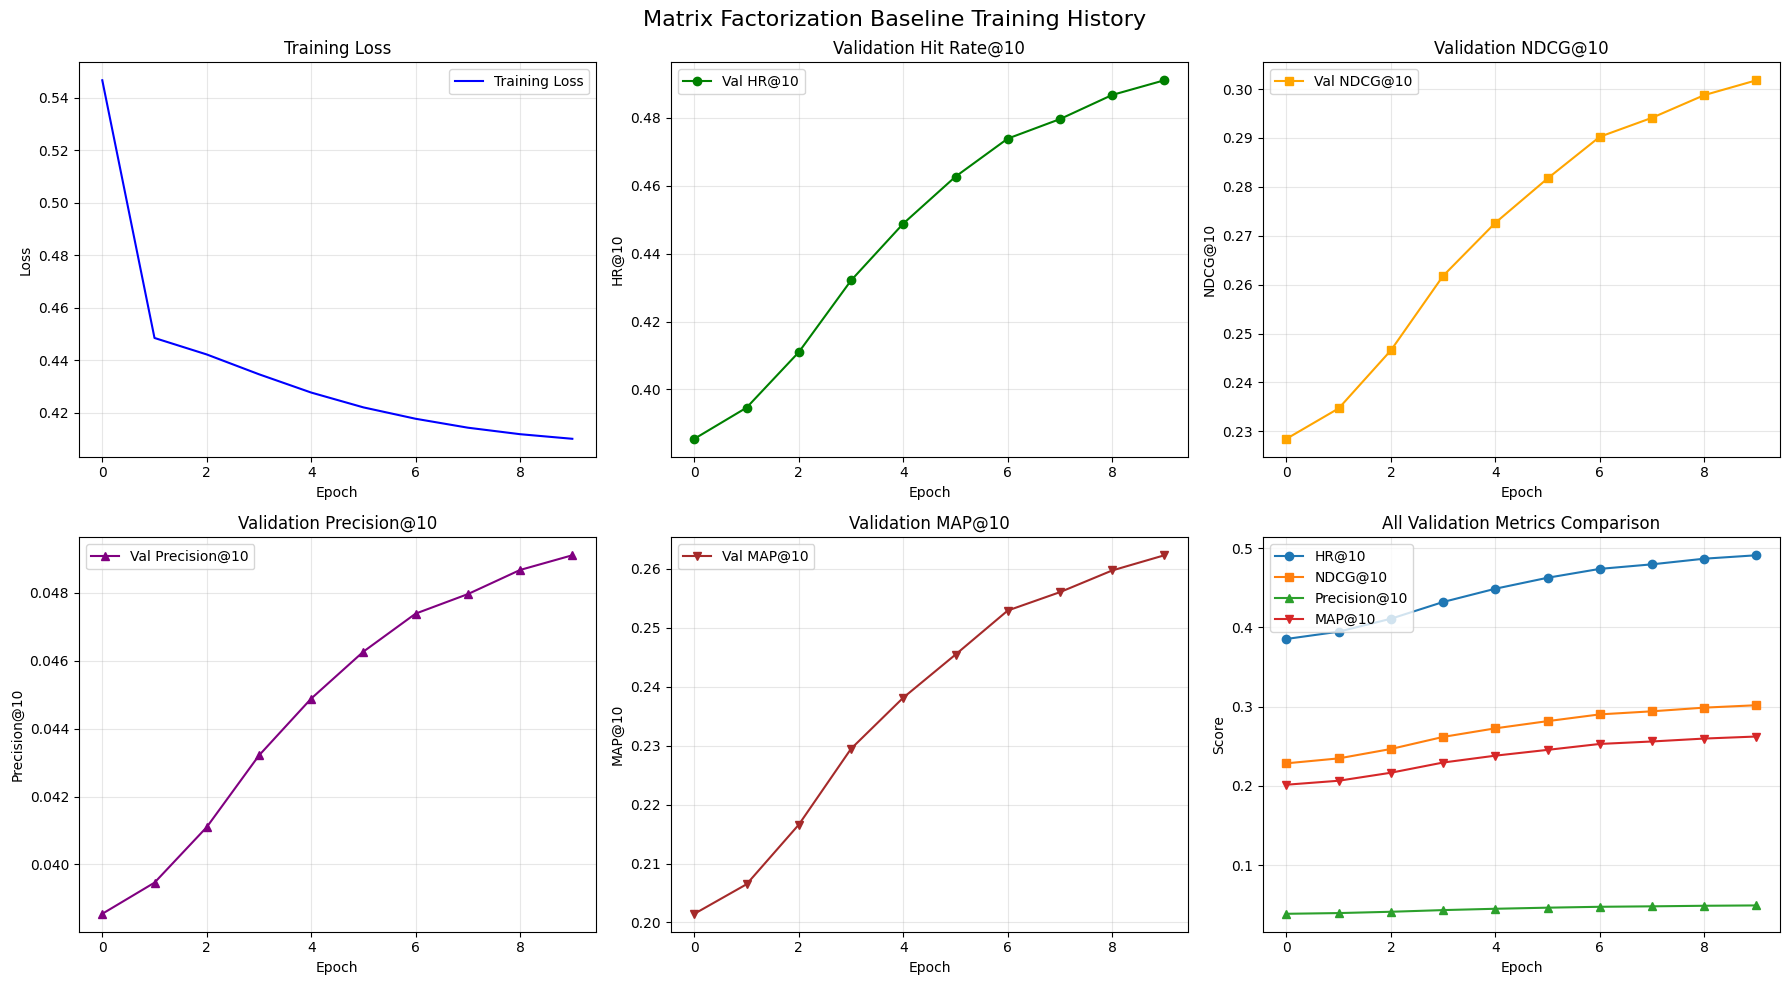

In [88]:
plot_training_history(
    train_losses,
    val_losses,
    val_metrics,
    k=10,
    model_name="Matrix Factorization Baseline",
    save_path="training_history.png"
)

## Testing cross-domain recommendation using the MF baseline

In [93]:
df_target = load_amazon_reviews_fast("Video_Games", max_items=None, seed=SEED)
print(f"Target domain data shape: {df_target.shape}")

Casting the dataset:   0%|          | 0/4624615 [00:00<?, ? examples/s]

Target domain data shape: (4624615, 6)


In [95]:
data_processor_target = preprocess_dataset(df_target, min_user_interactions=20, min_item_interactions=20)
filtered_df_target = le
calculate_data_sparsity(filtered_df_target)

After interactions filtering: 164839 rows, 5719 users, 19313 items
Number of users: 5719
Number of items: 19313
Number of interactions: 164839
------------------------------
Interaction Matrix Density: 0.0015
Interaction Matrix Sparsity: 0.9985


In [96]:
train_df_target, val_df_target, test_df_target = loo_split(filtered_df_target, oversample_verified=False, oversample_factor=1)
print(f"Target domain Train/Validation/Test split: {len(train_df_target)}, {len(val_df_target)}, {len(test_df_target)}")

Target domain Train/Validation/Test split: 153459, 5690, 5690


In [98]:
NUM_USERS_TARGET = filtered_df_target["user_id"].max() + 1
NUM_ITEMS_TARGET = filtered_df_target["item_id"].max() + 1

In [99]:
pos_items_by_user_target = build_pos_items_by_user(train_df_target)

In [100]:
target_ds_scratch = CustomDataset(train_df_target, num_items=NUM_ITEMS_TARGET, pos_by_user=pos_items_by_user_target, n_neg=4, mode="train", seed=SEED)
target_loader_scratch = DataLoader(target_ds_scratch, batch_size=4096, shuffle=True)

target_ds_transfer = CustomDataset(val_df_target, num_items=NUM_ITEMS_TARGET, pos_by_user=pos_items_by_user_target, n_neg=99, mode="val", seed=SEED)
taret_loader_scratch = DataLoader(target_ds_transfer, batch_size=4096, shuffle=False)

target_ds_test = CustomDataset(test_df_target, num_items=NUM_ITEMS_TARGET, pos_by_user=pos_items_by_user_target, n_neg=99, mode="test", seed=SEED)
target_loader_test = DataLoader(target_ds_test, batch_size=4096, shuffle=False)

print(f"Target domain training dataset created with {len(target_ds_scratch)} samples.")
print(f"Target domain validation dataset created with {len(target_ds_transfer)} samples.")
print(f"Target domain test dataset created with {len(target_ds_test)} samples.")

Target domain training dataset created with 767295 samples.
Target domain validation dataset created with 5690 samples.
Target domain test dataset created with 5690 samples.


## Model 1: Neural Matrix Factorization Model

In [89]:
class NeuralMF(nn.Module):
    """
    NeuMF: GMF (dot-style) + MLP (nonlinear) with optional user/item/global biases.
    Returns raw logits suitable for BCEWithLogitsLoss.
    """
    def __init__(
        self,
        n_users: int,
        n_items: int,
        gmf_dim: int = 32,
        mlp_dim: int = 32,
        mlp_layers=(64, 32, 16),
        dropout: float = 0.1,
        use_bias: bool = True,
    ):
        super().__init__()
        # GMF branch
        self.user_emb_gmf = nn.Embedding(n_users, gmf_dim)
        self.item_emb_gmf = nn.Embedding(n_items, gmf_dim)

        # MLP branch
        self.user_emb_mlp = nn.Embedding(n_users, mlp_dim)
        self.item_emb_mlp = nn.Embedding(n_items, mlp_dim)

        mlp_blocks = []
        in_dim = mlp_dim * 2
        for h in mlp_layers:
            mlp_blocks.append(nn.Linear(in_dim, h))
            mlp_blocks.append(nn.ReLU())
            if dropout and dropout > 0:
                mlp_blocks.append(nn.Dropout(dropout))
            in_dim = h
        self.mlp = nn.Sequential(*mlp_blocks) if mlp_blocks else nn.Identity()

        # Final combine: concat(GMF, MLP) -> 1
        final_in = gmf_dim + (mlp_layers[-1] if mlp_blocks else mlp_dim * 2)
        self.fc_out = nn.Linear(final_in, 1)

        self.use_bias = use_bias
        if use_bias:
            self.user_bias = nn.Embedding(n_users, 1)
            self.item_bias = nn.Embedding(n_items, 1)
        else:
            self.user_bias = None
            self.item_bias = None
        self.global_bias = nn.Parameter(torch.zeros(1))

        self._reset_parameters()

    def _reset_parameters(self):
        for emb in [self.user_emb_gmf, self.item_emb_gmf, self.user_emb_mlp, self.item_emb_mlp]:
            nn.init.xavier_uniform_(emb.weight)
        for m in self.mlp:
            if isinstance(m, nn.Linear):
                nn.init.xavier_uniform_(m.weight)
                nn.init.zeros_(m.bias)
        nn.init.xavier_uniform_(self.fc_out.weight)
        nn.init.zeros_(self.fc_out.bias)
        if self.use_bias:
            nn.init.zeros_(self.user_bias.weight)
            nn.init.zeros_(self.item_bias.weight)

    def forward(self, user_ids, item_ids):
        # GMF
        gmf_u = self.user_emb_gmf(user_ids)           # [B, gmf_dim]
        gmf_i = self.item_emb_gmf(item_ids)           # [B, gmf_dim]
        gmf   = gmf_u * gmf_i                         # [B, gmf_dim]  (element-wise product)

        # MLP
        mlp_u = self.user_emb_mlp(user_ids)           # [B, mlp_dim]
        mlp_i = self.item_emb_mlp(item_ids)           # [B, mlp_dim]
        mlp   = torch.cat([mlp_u, mlp_i], dim=1)      # [B, 2*mlp_dim]
        mlp   = self.mlp(mlp)                          # [B, last_mlp_hidden]

        # Combine
        x = torch.cat([gmf, mlp], dim=1)              # [B, gmf_dim + last_mlp_hidden]
        logit = self.fc_out(x).squeeze(-1)            # [B]

        if self.use_bias:
            logit = logit + self.user_bias(user_ids).squeeze(-1) + self.item_bias(item_ids).squeeze(-1)
        logit = logit + self.global_bias
        return logit

    @torch.no_grad()
    def predict_all_items(self, user_id: int) -> torch.Tensor:
        """
        Vectorized scoring for all items; returns raw logits.
        """
        device = next(self.parameters()).device
        u = torch.tensor([user_id], dtype=torch.long, device=device)
        all_items = torch.arange(self.item_emb_gmf.num_embeddings, dtype=torch.long, device=device)

        # GMF
        gmf_u = self.user_emb_gmf(u)                          # [1, gmf_dim]
        gmf_i = self.item_emb_gmf(all_items)                  # [N, gmf_dim]
        gmf   = (gmf_u * gmf_i)                               # [N, gmf_dim]

        # MLP
        mlp_u = self.user_emb_mlp(u).expand(all_items.numel(), -1)  # [N, mlp_dim]
        mlp_i = self.item_emb_mlp(all_items)                         # [N, mlp_dim]
        mlp   = torch.cat([mlp_u, mlp_i], dim=1)                     # [N, 2*mlp_dim]
        mlp   = self.mlp(mlp)                                        # [N, last_mlp_hidden]

        x = torch.cat([gmf, mlp], dim=1)                             # [N, gmf_dim+last]
        logit = self.fc_out(x).squeeze(-1)                           # [N]

        if self.use_bias:
            logit = logit + self.user_bias(u).squeeze(-1) + self.item_bias(all_items).squeeze(-1)
        logit = logit + self.global_bias
        return logit

In [90]:
neumf = NeuralMF(
    n_users=NUM_USERS,
    n_items=NUM_ITEMS,
    gmf_dim=32,
    mlp_dim=32,
    mlp_layers=(64, 32, 16),
    dropout=0.2,
    use_bias=True
).to(DEVICE)

loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(neumf.parameters(), lr=1e-3, weight_decay=1e-6)  # a bit higher LR works well for NeuMF

train_losses_neumf, val_losses_neumf, val_metrics_neumf, best_ndcg_neumf = model_trainer(
    model=neumf,
    train_loader=train_loader,
    eval_loader=val_loader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    epochs=10,
    k=10,
    device=DEVICE,
    save_dir="model_neumf"
)

best_neumf = load_best_weights(neumf, ckpt_path="model_neumf/best_model.pth", device=DEVICE)
results_neumf = final_evaluation_loader(best_neumf, test_loader, loss_fn, device=DEVICE)

Evaluating: 100%|██████████| 19/19 [00:00<00:00, 25.60it/s]


Epoch 1/10  Train loss 0.4244  Val loss 0.1905  HR@10 0.4458  NDCG@10 0.2683  Precision@10 0.0446  MAP@10 0.2337  (new best)  Time 105.69s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 26.47it/s]


Epoch 2/10  Train loss 0.3436  Val loss 0.1697  HR@10 0.5456  NDCG@10 0.3342  Precision@10 0.0546  MAP@10 0.2880  (new best)  Time 103.66s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 27.96it/s]


Epoch 3/10  Train loss 0.3078  Val loss 0.1649  HR@10 0.5724  NDCG@10 0.3519  Precision@10 0.0572  MAP@10 0.3022  (new best)  Time 106.46s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 25.01it/s]


Epoch 4/10  Train loss 0.2908  Val loss 0.1611  HR@10 0.5872  NDCG@10 0.3651  Precision@10 0.0587  MAP@10 0.3142  (new best)  Time 105.28s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 26.36it/s]


Epoch 5/10  Train loss 0.2789  Val loss 0.1568  HR@10 0.5954  NDCG@10 0.3712  Precision@10 0.0595  MAP@10 0.3194  (new best)  Time 112.18s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 26.35it/s]


Epoch 6/10  Train loss 0.2689  Val loss 0.1535  HR@10 0.6053  NDCG@10 0.3809  Precision@10 0.0605  MAP@10 0.3284  (new best)  Time 106.48s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 23.28it/s]


Epoch 7/10  Train loss 0.2605  Val loss 0.1505  HR@10 0.6153  NDCG@10 0.3894  Precision@10 0.0615  MAP@10 0.3361  (new best)  Time 108.41s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 26.43it/s]


Epoch 8/10  Train loss 0.2523  Val loss 0.1508  HR@10 0.6230  NDCG@10 0.3941  Precision@10 0.0623  MAP@10 0.3395  (new best)  Time 106.87s


Evaluating: 100%|██████████| 19/19 [00:00<00:00, 26.74it/s]


Epoch 9/10  Train loss 0.2452  Val loss 0.1486  HR@10 0.6283  NDCG@10 0.4000  Precision@10 0.0628  MAP@10 0.3454  (new best)  Time 103.69s


Evaluating: 100%|██████████| 19/19 [00:01<00:00, 17.79it/s]


Epoch 10/10  Train loss 0.2388  Val loss 0.1449  HR@10 0.6339  NDCG@10 0.4054  Precision@10 0.0634  MAP@10 0.3503  (new best)  Time 107.13s

Training Complete.
Best epoch: 10 with NDCG@10: 0.4054




Evaluating: 100%|██████████| 19/19 [00:00<00:00, 29.86it/s]

     HR@K  NDCG@K  Precision@K
K                             
5  0.4282  0.3086       0.0856
10 0.5631  0.3522       0.0563
20 0.7048  0.3880       0.0352
50 0.8890  0.4247       0.0178


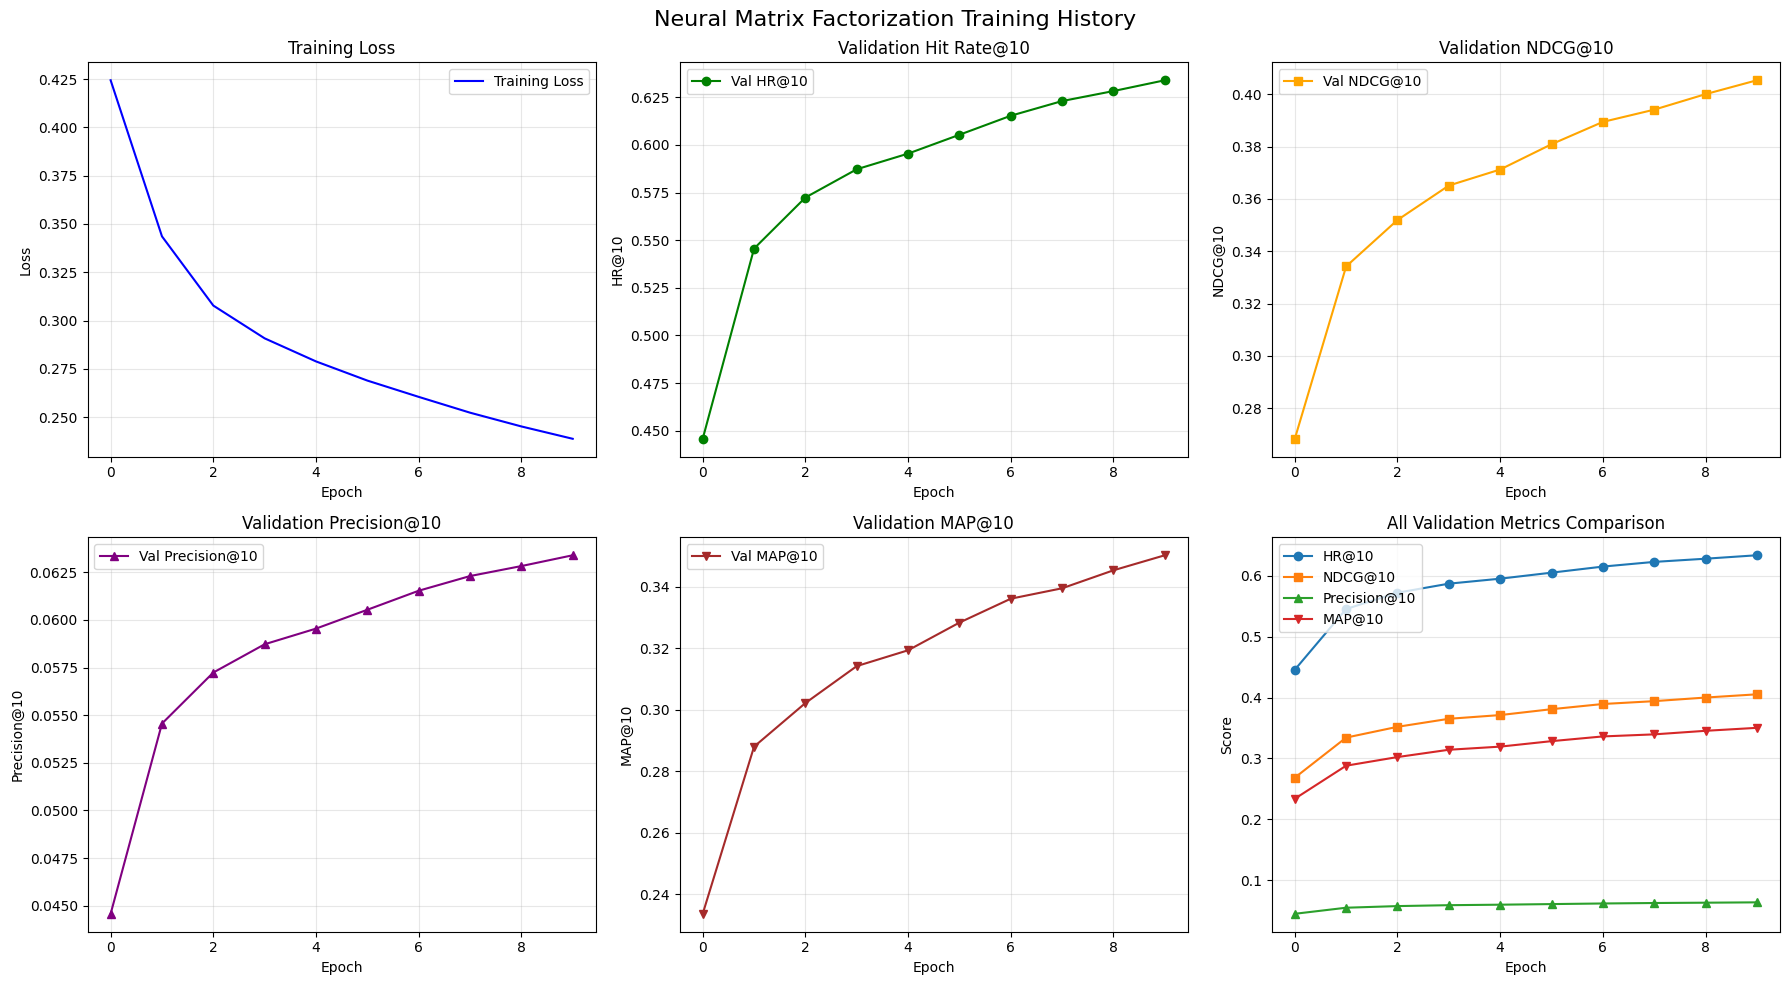

In [91]:
plot_training_history(
    train_losses_neumf,
    val_losses_neumf,
    val_metrics_neumf,
    k=10,
    model_name="Neural Matrix Factorization",
    save_path="training_history_neumf.png"
)

## Model 2: SASRec Model
Transformer-based model for sequential recommendation from the paper [Self-Attentive Sequential Recommendation (2018)](https://arxiv.org/abs/1808.09781).

* **Data:** build per-user, time-sorted history sequences (left-padded to max length in batch). For training, use history -> next item triples + one negative per triples.
* **Model:** Item embeddings + positional embeddings -> Transformer encoder with causal mask. Take final position representation as the user's state and score candidate items by dot-product.
* **Eval:** Identical to the baseline using LOO setting.

In [92]:
def create_user_sequences(df):
    df_sorted = df.sort_values(["user_id", "timestamp"])
    user_sequences = {}
    user_seq_lens = []
    for uid, group in tqdm(df_sorted.groupby("user_id"), desc="Building user sequences"):
        items = group["item_id"].tolist()
        if len(items) >= 3:  # Need at least 3 for train/val/test split
            user_sequences[uid] = items
            user_seq_lens.append(len(items))

    print(f"Created sequences for {len(user_sequences)} users.")
    print(f"Average sequence length: {np.mean(user_seq_lens):.2f}")
    print(f"Max sequence length: {np.max(user_seq_lens)}")
    print(f"Min sequence length: {np.min(user_seq_lens)}")

    return {
        "sequences": user_sequences,
        "avg_seq_len": np.mean(user_seq_lens),
        "num_users": len(user_sequences)
    }

class SASRecDataset(Dataset):
    def __init__(self, user_sequences, num_items, max_seq_len=50, mode="train", neg_samples=1):
        self.user_sequences = user_sequences
        self.num_items = num_items
        self.max_seq_len = max_seq_len
        self.mode = mode
        self.neg_samples = neg_samples

        # Convert to list for indexing
        self.users = list(user_sequences.keys())

        # Build set of all items each user has interacted with (for negative sampling)
        self.user_item_set = {
            u: set(items) for u, items in user_sequences.items()
        }

    def __len__(self):
        return len(self.users)

    def __getitem__(self, idx):
        user = self.users[idx]
        seq = self.user_sequences[user]

        if self.mode == "train":
            # For training: use all but last two items
            input_seq = seq[:-2] if len(seq) > 2 else seq[:-1]
            target = seq[-2] if len(seq) > 2 else seq[-1]
        elif self.mode == "val":
            # For validation: use all but last item to predict second-to-last
            input_seq = seq[:-2]
            target = seq[-2]
        else:  # test
            # For test: use all but last to predict last
            input_seq = seq[:-1]
            target = seq[-1]

        # Pad sequence to max_seq_len
        input_seq = self._process_sequence(input_seq)

        # Sample negative items
        neg_items = self._sample_negatives(user)

        return {
            "user": user,
            "input_seq": torch.tensor(input_seq, dtype=torch.long),
            "target": target,
            "neg_items": torch.tensor(neg_items, dtype=torch.long)
        }

    def _process_sequence(self, seq):
        if len(seq) > self.max_seq_len:
            # Keep only the most recent max_seq_len items
            seq = seq[-self.max_seq_len:]
        elif len(seq) < self.max_seq_len:
            # Pad with zeros at the beginning
            seq = [0] * (self.max_seq_len - len(seq)) + seq
        return seq

    def _sample_negatives(self, user):
        neg_items = []
        user_items = self.user_item_set[user]
        while len(neg_items) < self.neg_samples:
            neg = random.randint(1, self.num_items - 1)  # 0 is padding
            if neg not in user_items:
                neg_items.append(neg)
        return neg_items

user_sequences = create_user_sequences(filtered_df)

# Use the same train/val/test split as before
train_users = set(train_df["user_id"].unique())
val_users = set(val_df["user_id"].unique())
test_users = set(test_df["user_id"].unique())

# Filter user sequences to match the splits
train_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in train_users}
val_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in val_users}
test_sequences = {u: seq for u, seq in user_sequences["sequences"].items() if u in test_users}

print(f"Train sequences: {len(train_sequences)} users")
print(f"Validation sequences: {len(val_sequences)} users")
print(f"Test sequences: {len(test_sequences)} users")

Building user sequences: 100%|██████████| 75821/75821 [00:03<00:00, 22585.84it/s]


Created sequences for 75696 users.
Average sequence length: 33.78
Max sequence length: 2344
Min sequence length: 3
Train sequences: 75696 users
Validation sequences: 75510 users
Test sequences: 75510 users


In [ ]:
train_dataset_sasrec = SASRecDataset(train_sequences, num_items=NUM_ITEMS, max_seq_len=50, mode="train", neg_samples=1)
val_dataset_sasrec = SASRecDataset(val_sequences, num_items=NUM_ITEMS, max_seq_len=50, mode="val", neg_samples=99)
test_dataset_sasrec = SASRecDataset(test_sequences, num_items=NUM_ITEMS, max_seq_len=50, mode="test", neg_samples=99)